In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [25]:
df = pd.read_csv(csv_path)  # uses your csv_path from before
df['Date'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str).str.zfill(2) + '-15'
)
df.set_index('Date', inplace=True)
series = df['Seasonally Adjusted CO2 (ppm)'].dropna()

In [26]:
# ─── 2. First‐difference to remove the rising trend ─────────────────
series_diff = series.diff().dropna()

Diff series range: -0.86 to 1.46


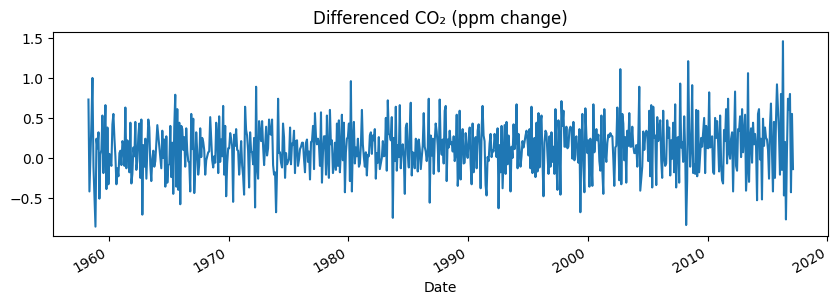

In [27]:
# Optional inspect
print(f"Diff series range: {series_diff.min():.2f} to {series_diff.max():.2f}")
series_diff.plot(title='Differenced CO₂ (ppm change)', figsize=(10,3))
plt.show()

In [28]:
# ─── 3. Normalize the differenced series (z‑score) ─────────────────
mu, sigma = series_diff.mean(), series_diff.std()
series_norm = (series_diff - mu) / sigma

In [29]:
window_len = 30
def make_windows(x, w):
    return np.stack([x[i:i+w] for i in range(len(x)-w)], axis=0)

X_all = make_windows(series_norm.values, window_len)
y_all = series_norm.values[window_len:]


In [30]:
# reshape for CNN
X_all = X_all[..., np.newaxis]

In [31]:
split = int(0.7 * len(X_all))
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [32]:
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(window_len,1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.fit(
    X_train, y_train,
    epochs=30, batch_size=32,
    validation_split=0.1, verbose=2
)

Epoch 1/30
14/14 - 3s - 232ms/step - loss: 0.8132 - val_loss: 0.8900
Epoch 2/30
14/14 - 0s - 7ms/step - loss: 0.7679 - val_loss: 0.8975
Epoch 3/30
14/14 - 0s - 7ms/step - loss: 0.7356 - val_loss: 0.8841
Epoch 4/30
14/14 - 0s - 7ms/step - loss: 0.7118 - val_loss: 0.8848
Epoch 5/30
14/14 - 0s - 7ms/step - loss: 0.7053 - val_loss: 0.8959
Epoch 6/30
14/14 - 0s - 7ms/step - loss: 0.6748 - val_loss: 0.9308
Epoch 7/30
14/14 - 0s - 7ms/step - loss: 0.6352 - val_loss: 0.9677
Epoch 8/30
14/14 - 0s - 7ms/step - loss: 0.5928 - val_loss: 0.9418
Epoch 9/30
14/14 - 0s - 7ms/step - loss: 0.5568 - val_loss: 0.9106
Epoch 10/30
14/14 - 0s - 7ms/step - loss: 0.5069 - val_loss: 1.0047
Epoch 11/30
14/14 - 0s - 7ms/step - loss: 0.4948 - val_loss: 1.0346
Epoch 12/30
14/14 - 0s - 7ms/step - loss: 0.4141 - val_loss: 0.9648
Epoch 13/30
14/14 - 0s - 7ms/step - loss: 0.3790 - val_loss: 0.9492
Epoch 14/30
14/14 - 0s - 7ms/step - loss: 0.3266 - val_loss: 1.0455
Epoch 15/30
14/14 - 0s - 7ms/step - loss: 0.3086 - val_

In [34]:
y_pred_train = model.predict(X_train).flatten()
y_pred_test  = model.predict(X_test).flatten()
err_train    = np.abs(y_train - y_pred_train)
err_test     = np.abs(y_test  - y_pred_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [35]:
threshold = err_train.mean() + 3 * err_train.std()
print(f"Threshold = {threshold:.3f}")


Threshold = 1.162


In [36]:
flags = err_test > threshold
print(f"Anomalies: {flags.sum()} / {len(flags)} windows")

Anomalies: 77 / 202 windows


In [37]:
diff_index = series_diff.index[window_len:]
dates_test = diff_index[split : split + len(flags)]
anomaly_dates = dates_test[flags]


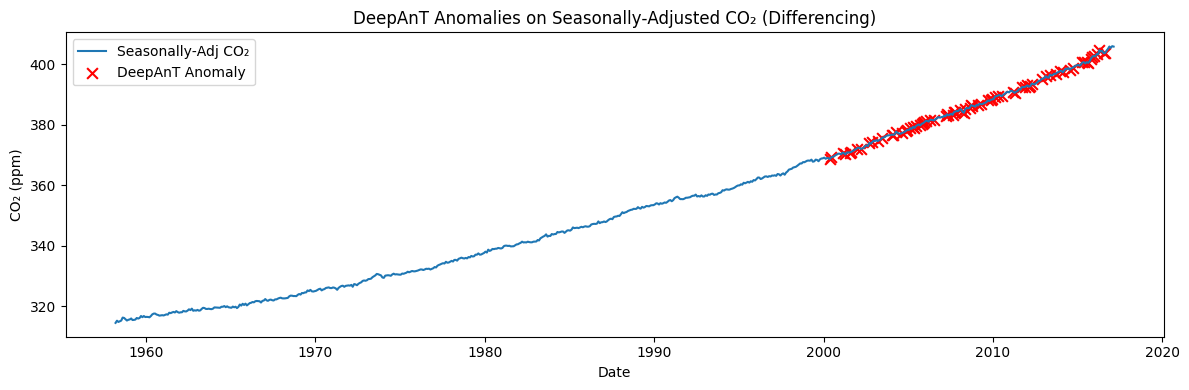

In [38]:
plt.figure(figsize=(12,4))
plt.plot(series.index, series.values, label='Seasonally‑Adj CO₂')
plt.scatter(
    anomaly_dates,
    series.loc[anomaly_dates],
    c='r', marker='x', s=60,
    label='DeepAnT Anomaly'
)
plt.title('DeepAnT Anomalies on Seasonally‑Adjusted CO₂ (Differencing)')
plt.xlabel('Date')
plt.ylabel('CO₂ (ppm)')
plt.legend()
plt.tight_layout()
plt.show()

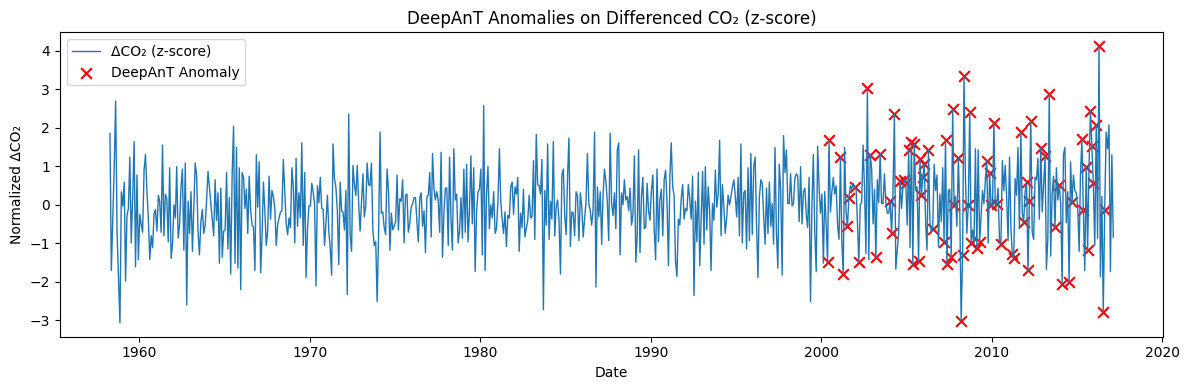

In [39]:
# ─── Plot on the DIFFERENCED & NORMALIZED series ─────────────────────
plt.figure(figsize=(12,4))
plt.plot(
    series_norm.index, 
    series_norm.values, 
    label='ΔCO₂ (z‑score)', 
    lw=1
)
plt.scatter(
    anomaly_dates,
    series_norm.loc[anomaly_dates],
    c='r', marker='x', s=60,
    label='DeepAnT Anomaly'
)
plt.title('DeepAnT Anomalies on Differenced CO₂ (z‑score)')
plt.xlabel('Date')
plt.ylabel('Normalized ΔCO₂')
plt.legend()
plt.tight_layout()
plt.show()
